In [1]:
import pip
REQUIRED_MINIMUM_PANDAS_VERSION = '0.17.1'
try:
    import pandas as pd
    assert pd.__version__ >= REQUIRED_MINIMUM_PANDAS_VERSION
except:
    raise Exception("Version %s or above of Pandas is required to run this notebook" % REQUIRED_MINIMUM_PANDAS_VERSION)

In [2]:
import sys
try:
    import docplex.mp
except:
    if hasattr(sys, 'real_prefix'):
        #we are in a virtual env.
        !pip install docplex 
    else:
        !pip install --user docplex    

    100% |████████████████████████████████| 460kB 1.9MB/s eta 0:00:01
Requirement not upgraded as not directly required: requests in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from docplex)
Requirement not upgraded as not directly required: six in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from docplex)
Requirement not upgraded as not directly required: chardet<3.1.0,>=3.0.2 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from requests->docplex)
Requirement not upgraded as not directly required: idna<2.7,>=2.5 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from requests->docplex)
Requirement not upgraded as not directly required: urllib3<1.23,>=1.21.1 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from requests->docplex)
Requirement not upgraded as not directly required: certifi>=2017.4.17 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from requests->docplex)
  Running setup.py bdist_wheel for docplex 

In [3]:
url = "https://api-oaas.docloud.ibmcloud.com/job_manager/rest/v1/"
key = "api_xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"

In [4]:
# This notebook requires pandas to work
from io import StringIO
import json
import pandas as pd
from pandas import DataFrame

# Make sure that xlrd package, which is a pandas optional dependency, is installed
# This package is required for Excel I/O
try:
    import xlrd
except:
    if hasattr(sys, 'real_prefix'):
        #we are in a virtual env.
        !pip install xlrd 
    else:
        !pip install --user xlrd

In [5]:
# Use pandas to read the file, one tab for each table.
nurse_xls_file = pd.ExcelFile("https://apsportal.ibm.com/exchange-api/v1/entries/2505b070a22403aac9f84884d315219e/data?accessKey=38990e0e17b15be6df05d384006a1d06")
df_skills = nurse_xls_file.parse('Skills')
df_depts  = nurse_xls_file.parse('Departments')
df_shifts = nurse_xls_file.parse('Shifts')
# Rename df_shifts index
df_shifts.index.name = 'shiftId'

# Index is column 0: name
df_nurses = nurse_xls_file.parse('Nurses', header=0, index_col=0)
df_nurse_skilles = nurse_xls_file.parse('NurseSkills')
df_vacations = nurse_xls_file.parse('NurseVacations')
df_associations = nurse_xls_file.parse('NurseAssociations')
df_incompatibilities = nurse_xls_file.parse('NurseIncompatibilities')

# Display the nurses dataframe
print("#nurses = {}".format(len(df_nurses)))
print("#shifts = {}".format(len(df_shifts)))
print("#vacations = {}".format(len(df_vacations)))

#nurses = 32
#shifts = 41
#vacations = 59


In [6]:
# maximum work time (in hours)
max_work_time = 40

# maximum number of shifts worked in a week.
max_nb_shifts = 5

In [7]:
df_shifts

,department,day,start_time,end_time,min_req,max_req
shiftId,,,,,,
0,Emergency,Monday,2,8,3,5
1,Emergency,Monday,8,12,4,7
2,Emergency,Monday,12,18,2,5
3,Emergency,Monday,18,2,3,7
4,Consultation,Monday,8,12,10,13
5,Consultation,Monday,12,18,8,12
6,Cardiac Care,Monday,8,12,10,13
7,Cardiac Care,Monday,12,18,8,12
8,Emergency,Tuesday,8,12,4,7


In [8]:
days = ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"]
day_of_weeks = dict(zip(days, range(7)))

# utility to convert a day string e.g. "Monday" to an integer in 0..6
def day_to_day_of_week(day):
    return day_of_weeks[day.strip().lower()]

# for each day name, we normalize it by stripping whitespace and converting it to lowercase
# " Monday" -> "monday"
df_shifts["dow"] = df_shifts.day.apply(day_to_day_of_week)
df_shifts

,department,day,start_time,end_time,min_req,max_req,dow
shiftId,,,,,,,
0,Emergency,Monday,2,8,3,5,0
1,Emergency,Monday,8,12,4,7,0
2,Emergency,Monday,12,18,2,5,0
3,Emergency,Monday,18,2,3,7,0
4,Consultation,Monday,8,12,10,13,0
5,Consultation,Monday,12,18,8,12,0
6,Cardiac Care,Monday,8,12,10,13,0
7,Cardiac Care,Monday,12,18,8,12,0
8,Emergency,Tuesday,8,12,4,7,1


In [9]:
df_shifts["wstart"] = df_shifts.start_time + 24 * df_shifts.dow

In [10]:
# an auxiliary function to calculate absolute end time of a shift
def calculate_absolute_endtime(start, end, dow):
    return 24*dow + end + (24 if start>=end else 0)

# store the results in a new column
df_shifts["wend"] = df_shifts.apply(lambda row: calculate_absolute_endtime(
        row.start_time, row.end_time, row.dow), axis=1, raw=True)

In [11]:
df_shifts["duration"] = df_shifts.wend - df_shifts.wstart

In [12]:
# also compute minimum demand in nurse-hours
df_shifts["min_demand"] = df_shifts.min_req * df_shifts.duration

# finally check the modified shifts dataframe
df_shifts

,department,day,start_time,end_time,min_req,max_req,dow,wstart,wend,duration,min_demand
shiftId,,,,,,,,,,,
0,Emergency,Monday,2,8,3,5,0,2,8,6,18
1,Emergency,Monday,8,12,4,7,0,8,12,4,16
2,Emergency,Monday,12,18,2,5,0,12,18,6,12
3,Emergency,Monday,18,2,3,7,0,18,26,8,24
4,Consultation,Monday,8,12,10,13,0,8,12,4,40
5,Consultation,Monday,12,18,8,12,0,12,18,6,48
6,Cardiac Care,Monday,8,12,10,13,0,8,12,4,40
7,Cardiac Care,Monday,12,18,8,12,0,12,18,6,48
8,Emergency,Tuesday,8,12,4,7,1,32,36,4,16


In [13]:
from docplex.mp.environment import Environment
env = Environment()
env.print_information()

* system is: Linux 64bit
* Python is present, version is 3.5.4
* docplex is present, version is (2, 6, 94)
* CPLEX wrapper is not available


In [14]:
from docplex.mp.model import Model
mdl = Model(name="nurses")

In [15]:
# first global collections to iterate upon
all_nurses = df_nurses.index.values
all_shifts = df_shifts.index.values

# the assignment variables.
assigned = mdl.binary_var_matrix(keys1=all_nurses, keys2=all_shifts, name="assign_%s_%s")

In [16]:
# Organize decision variables in a DataFrame
df_assigned = DataFrame({'assigned': assigned})
df_assigned.index.names=['all_nurses', 'all_shifts']

# Create a pivot using nurses and shifts index as dimensions
df_assigned_pivot = df_assigned.reset_index().pivot(index='all_nurses', columns='all_shifts', values='assigned')

# Display first rows of the pivot table
df_assigned_pivot.head()

all_shifts,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
all_nurses,,,,,,,,,,,,,,,,,,,,,
Anne,assign_Anne_0,assign_Anne_1,assign_Anne_2,assign_Anne_3,assign_Anne_4,assign_Anne_5,assign_Anne_6,assign_Anne_7,assign_Anne_8,assign_Anne_9,...,assign_Anne_31,assign_Anne_32,assign_Anne_33,assign_Anne_34,assign_Anne_35,assign_Anne_36,assign_Anne_37,assign_Anne_38,assign_Anne_39,assign_Anne_40
Bethanie,assign_Bethanie_0,assign_Bethanie_1,assign_Bethanie_2,assign_Bethanie_3,assign_Bethanie_4,assign_Bethanie_5,assign_Bethanie_6,assign_Bethanie_7,assign_Bethanie_8,assign_Bethanie_9,...,assign_Bethanie_31,assign_Bethanie_32,assign_Bethanie_33,assign_Bethanie_34,assign_Bethanie_35,assign_Bethanie_36,assign_Bethanie_37,assign_Bethanie_38,assign_Bethanie_39,assign_Bethanie_40
Betsy,assign_Betsy_0,assign_Betsy_1,assign_Betsy_2,assign_Betsy_3,assign_Betsy_4,assign_Betsy_5,assign_Betsy_6,assign_Betsy_7,assign_Betsy_8,assign_Betsy_9,...,assign_Betsy_31,assign_Betsy_32,assign_Betsy_33,assign_Betsy_34,assign_Betsy_35,assign_Betsy_36,assign_Betsy_37,assign_Betsy_38,assign_Betsy_39,assign_Betsy_40
Cathy,assign_Cathy_0,assign_Cathy_1,assign_Cathy_2,assign_Cathy_3,assign_Cathy_4,assign_Cathy_5,assign_Cathy_6,assign_Cathy_7,assign_Cathy_8,assign_Cathy_9,...,assign_Cathy_31,assign_Cathy_32,assign_Cathy_33,assign_Cathy_34,assign_Cathy_35,assign_Cathy_36,assign_Cathy_37,assign_Cathy_38,assign_Cathy_39,assign_Cathy_40
Cecilia,assign_Cecilia_0,assign_Cecilia_1,assign_Cecilia_2,assign_Cecilia_3,assign_Cecilia_4,assign_Cecilia_5,assign_Cecilia_6,assign_Cecilia_7,assign_Cecilia_8,assign_Cecilia_9,...,assign_Cecilia_31,assign_Cecilia_32,assign_Cecilia_33,assign_Cecilia_34,assign_Cecilia_35,assign_Cecilia_36,assign_Cecilia_37,assign_Cecilia_38,assign_Cecilia_39,assign_Cecilia_40


In [17]:
# Create a Data Frame representing a list of shifts sorted by wstart and duration.
# One keeps only the three relevant columns: 'shiftId', 'wstart' and 'wend' in the resulting Data Frame 
df_sorted_shifts = df_shifts.sort_values(['wstart','duration']).reset_index()[['shiftId', 'wstart', 'wend']]

# Display the first rows of the newly created Data Frame
df_sorted_shifts.head()

,shiftId,wstart,wend
0,0,2,8
1,1,8,12
2,4,8,12
3,6,8,12
4,2,12,18


In [18]:
number_of_incompatible_shift_constraints = 0
for shift in df_sorted_shifts.itertuples():
    # Iterate over following shifts
    # 'shift[0]' contains the index of the current shift in the df_sorted_shifts Data Frame
    for shift_2 in df_sorted_shifts.iloc[shift[0] + 1:].itertuples():
        if (shift_2.wstart < shift.wend):
            # Iterate over all nurses to force incompatible assignment for the current pair of overlapping shifts
            for nurse_assignments in df_assigned_pivot[[shift.shiftId, shift_2.shiftId]].itertuples():
                # this is actually a logical OR
                mdl.add_constraint(nurse_assignments[1] + nurse_assignments[2] <= 1)
                number_of_incompatible_shift_constraints += 1
        else:
            # No need to test overlap with following shifts
            break
print("#incompatible shift constraints: {}".format(number_of_incompatible_shift_constraints))

#incompatible shift constraints: 640


In [19]:
# Add 'day of week' column to vacations Data Frame
df_vacations['dow'] = df_vacations.day.apply(day_to_day_of_week)

# Join 'df_vacations', 'df_shifts' and 'df_assigned' Data Frames to create the list of 'forbidden' assigments.
# The 'reset_index()' function is invoked to move 'shiftId' index as a column in 'df_shifts' Data Frame, and
# to move the index pair ('all_nurses', 'all_shifts') as columns in 'df_assigned' Data Frame.
# 'reset_index()' is invoked so that a join can be performed between Data Frame, based on column names.
df_assigned_reindexed = df_assigned.reset_index()
df_vacation_forbidden_assignments = df_vacations.merge(df_shifts.reset_index()[['dow', 'shiftId']]).merge(
    df_assigned_reindexed, left_on=['nurse', 'shiftId'], right_on=['all_nurses', 'all_shifts'])

# Here are the first few rows of the resulting Data Frames joins
df_vacation_forbidden_assignments.head()

,nurse,day,dow,shiftId,all_nurses,all_shifts,assigned
0,Anne,Friday,4,28,Anne,28,assign_Anne_28
1,Anne,Friday,4,29,Anne,29,assign_Anne_29
2,Anne,Friday,4,30,Anne,30,assign_Anne_30
3,Anne,Friday,4,31,Anne,31,assign_Anne_31
4,Anne,Friday,4,32,Anne,32,assign_Anne_32


In [20]:
for forbidden_assignment in df_vacation_forbidden_assignments.itertuples():
    # to forbid an assignment just set the variable to zero.
    mdl.add_constraint(forbidden_assignment.assigned == 0)
print("# vacation forbids: {} assignments".format(len(df_vacation_forbidden_assignments)))

# vacation forbids: 342 assignments


In [21]:
# Join 'df_assignment' Data Frame twice, based on associations to get corresponding decision variables pairs for all shifts
# The 'suffixes' parameter in the second merge indicates our preference for updating the name of columns that occur both
# in the first and second argument Data Frames (in our case, these columns are 'all_nurses' and 'assigned').
df_preferred_assign = df_associations.merge(
    df_assigned_reindexed, left_on='nurse1', right_on='all_nurses').merge(
    df_assigned_reindexed, left_on=['nurse2', 'all_shifts'], right_on=['all_nurses', 'all_shifts'], suffixes=('_1','_2'))

# Here are the first few rows of the resulting Data Frames joins
df_preferred_assign.head()

,nurse1,nurse2,all_nurses_1,all_shifts,assigned_1,all_nurses_2,assigned_2
0,Isabelle,Dee,Isabelle,0,assign_Isabelle_0,Dee,assign_Dee_0
1,Isabelle,Dee,Isabelle,1,assign_Isabelle_1,Dee,assign_Dee_1
2,Isabelle,Dee,Isabelle,2,assign_Isabelle_2,Dee,assign_Dee_2
3,Isabelle,Dee,Isabelle,3,assign_Isabelle_3,Dee,assign_Dee_3
4,Isabelle,Dee,Isabelle,4,assign_Isabelle_4,Dee,assign_Dee_4


In [22]:
for preferred_assign in df_preferred_assign.itertuples():
    mdl.add_constraint(preferred_assign.assigned_1 == preferred_assign.assigned_2)

In [23]:
# Join assignment Data Frame twice, based on incompatibilities Data Frame to get corresponding decision variables pairs
#  for all shifts
df_incompatible_assign = df_incompatibilities.merge(
    df_assigned_reindexed, left_on='nurse1', right_on='all_nurses').merge(
    df_assigned_reindexed, left_on=['nurse2', 'all_shifts'], right_on=['all_nurses', 'all_shifts'], suffixes=('_1','_2'))

# Here are the first few rows of the resulting Data Frames joins
df_incompatible_assign.head()

,nurse1,nurse2,all_nurses_1,all_shifts,assigned_1,all_nurses_2,assigned_2
0,Patricia,Patrick,Patricia,0,assign_Patricia_0,Patrick,assign_Patrick_0
1,Patricia,Patrick,Patricia,1,assign_Patricia_1,Patrick,assign_Patrick_1
2,Patricia,Patrick,Patricia,2,assign_Patricia_2,Patrick,assign_Patrick_2
3,Patricia,Patrick,Patricia,3,assign_Patricia_3,Patrick,assign_Patrick_3
4,Patricia,Patrick,Patricia,4,assign_Patricia_4,Patrick,assign_Patrick_4


In [24]:
for incompatible_assign in df_incompatible_assign.itertuples():
    mdl.add_constraint(incompatible_assign.assigned_1 + incompatible_assign.assigned_2 <= 1)

In [25]:
# auxiliary function to create worktime variable from a row
def make_var(row, varname_fmt):
    return mdl.continuous_var(name=varname_fmt % row.name, lb=0)

# apply the function over nurse rows and store result in a new column
df_nurses["worktime"] = df_nurses.apply(lambda r: make_var(r, "worktime_%s"), axis=1)

# display nurse dataframe
df_nurses

,seniority,qualification,pay_rate,worktime
name,,,,
Anne,11,1,25,worktime_Anne
Bethanie,4,5,28,worktime_Bethanie
Betsy,2,2,17,worktime_Betsy
Cathy,2,2,17,worktime_Cathy
Cecilia,9,5,38,worktime_Cecilia
Chris,11,4,38,worktime_Chris
Cindy,5,2,21,worktime_Cindy
David,1,2,15,worktime_David
Debbie,7,2,24,worktime_Debbie


In [26]:
# Use pandas' groupby operation to enforce constraint calculating worktime for each nurse as the sum of all assigned
#  shifts times the duration of each shift
for nurse, nurse_assignments in df_assigned.groupby(level='all_nurses'):
    mdl.add_constraint(df_nurses.worktime[nurse] == mdl.dot(nurse_assignments.assigned, df_shifts.duration))
                       
# print model information and check we now have 32 extra continuous variables
mdl.print_information()

Model: nurses
 - number of variables: 1344
   - binary=1312, integer=0, continuous=32
 - number of constraints: 1547
   - linear=1547
 - parameters: defaults


In [27]:
# we use pandas' apply() method to set an upper bound on all worktime variables.
def set_max_work_time(v):
    v.ub = max_work_time
    # Optionally: return a string for fancy display of the constraint in the Output cell
    return str(v) + ' <= ' + str(v.ub)

df_nurses["worktime"].apply(convert_dtype=False, func=set_max_work_time)

name
Anne            worktime_Anne <= 40
Bethanie    worktime_Bethanie <= 40
Betsy          worktime_Betsy <= 40
Cathy          worktime_Cathy <= 40
Cecilia      worktime_Cecilia <= 40
Chris          worktime_Chris <= 40
Cindy          worktime_Cindy <= 40
David          worktime_David <= 40
Debbie        worktime_Debbie <= 40
Dee              worktime_Dee <= 40
Gloria        worktime_Gloria <= 40
Isabelle    worktime_Isabelle <= 40
Jane            worktime_Jane <= 40
Janelle      worktime_Janelle <= 40
Janice        worktime_Janice <= 40
Jemma          worktime_Jemma <= 40
Joan            worktime_Joan <= 40
Joyce          worktime_Joyce <= 40
Jude            worktime_Jude <= 40
Julie          worktime_Julie <= 40
Juliet        worktime_Juliet <= 40
Kate            worktime_Kate <= 40
Nancy          worktime_Nancy <= 40
Nathalie    worktime_Nathalie <= 40
Nicole        worktime_Nicole <= 40
Patricia    worktime_Patricia <= 40
Patrick      worktime_Patrick <= 40
Roberta      worktime_R

In [28]:
# Use pandas' groupby operation to enforce minimum requirement constraint for each shift
for shift, shift_nurses in df_assigned.groupby(level='all_shifts'):
    mdl.add_constraint(mdl.sum(shift_nurses.assigned) >= df_shifts.min_req[shift])

In [29]:
# again leverage pandas to create a series of expressions: costs of each nurse
total_salary_series = df_nurses.worktime * df_nurses.pay_rate

# compute global salary cost using pandas sum()
# Note that the result is a DOcplex expression: DOcplex if fully compatible with pandas
total_salary_cost = total_salary_series.sum()
mdl.add_kpi(total_salary_cost, "Total salary cost")

DecisionKPI(name=Total salary cost,expr=25worktime_Anne+28worktime_Bethanie+17worktime_Betsy+17worktime_..)

In [30]:
mdl.minimize(total_salary_cost)
mdl.print_information()

Model: nurses
 - number of variables: 1344
   - binary=1312, integer=0, continuous=32
 - number of constraints: 1588
   - linear=1588
 - parameters: defaults


In [31]:
# Set Cplex mipgap to 1e-5 to enforce precision to be of the order of a unit (objective value magnitude is ~1e+5).
mdl.parameters.mip.tolerances.mipgap = 1e-5

s = mdl.solve(url=url, key=key, log_output=True)
assert s, "solve failed"
mdl.report()

[2018-05-18T12:28:26Z, INFO] CPLEX version 12070100
[2018-05-18T12:28:26Z, INFO] Parameter file:
[2018-05-18T12:28:26Z, INFO] # -- This content is generated by DOcplex
[2018-05-18T12:28:26Z, INFO] CPLEX Parameter File Version 12.7.1.0
[2018-05-18T12:28:26Z, INFO] CPX_PARAM_EPGAP                  0.00001000000000
[2018-05-18T12:28:26Z, INFO] # --- end of generated prm data ---
[2018-05-18T12:28:26Z, WARN] Changed parameter CPX_PARAM_THREADS from 0 to 10
[2018-05-18T12:28:26Z, INFO] Param[1,067] = 10
[2018-05-18T12:28:26Z, INFO] Param[1,130] = utf-8
[2018-05-18T12:28:26Z, INFO] Param[1,132] = -1
[2018-05-18T12:28:26Z, INFO] Param[2,009] = 0.000010000000000000000818030539140313095458623138256371021270751953125
[2018-05-18T12:28:26Z, INFO] CPXPARAM_WorkDir                                 "/var/job_processor/work/tmp/java/job3719086006730360451.tmp"
[2018-05-18T12:28:26Z, INFO] CPXPARAM_Threads                                 10
[2018-05-18T12:28:26Z, INFO] CPXPARAM_Read_APIEncoding        

In [32]:
# Create a pandas Series containing actual shift assignment decision variables value
s_assigned = df_assigned.assigned.apply(lambda v: v.solution_value)

# Create a pivot table by (nurses, shifts), using pandas' "unstack" method to transform the 'all_shifts' row index
#  into columns
df_res = s_assigned.unstack(level='all_shifts')

# Display the first few rows of the resulting pivot table
df_res.head()

all_shifts,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
all_nurses,,,,,,,,,,,,,,,,,,,,,
Anne,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Bethanie,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Betsy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Cathy,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
Cecilia,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [33]:
s_demand  = df_shifts.min_req * df_shifts.duration
total_demand = s_demand.sum()
avg_worktime = total_demand / float(len(all_nurses))
print("* theoretical average work time is {0:g} h".format(avg_worktime))

* theoretical average work time is 39 h


In [34]:
# a pandas series of worktimes solution values
s_worktime = df_nurses.worktime.apply(lambda v: v.solution_value)

# returns a new series computed as deviation from average
s_to_mean = s_worktime - avg_worktime

# take the absolute value
s_abs_to_mean = s_to_mean.apply(abs)


total_to_mean = s_abs_to_mean.sum()
print("* the sum of absolute deviations from mean is {}".format(total_to_mean))

* the sum of absolute deviations from mean is 58.0


Text(0.5,0,'worktime')

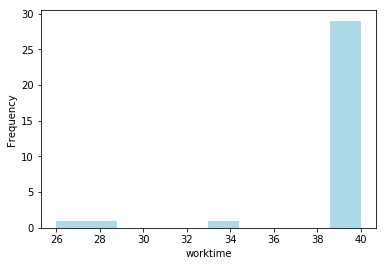

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

# we can also plot as a histogram the distribution of worktimes
s_worktime.plot.hist(color='LightBlue')
plt.xlabel("worktime")

Text(0,0.5,'#shifts worked')

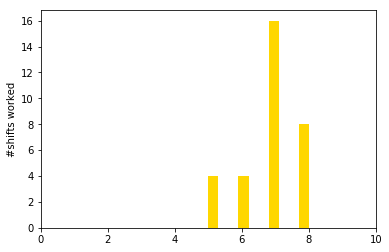

In [36]:
# a pandas series of #shifts worked
df_worked = df_res[all_shifts].sum(axis=1)
df_res["worked"] = df_worked

df_worked.plot.hist(color="gold", xlim=(0,10))
plt.ylabel("#shifts worked")

In [37]:
avg_worked = df_shifts["min_req"].sum() / float(len(all_nurses))
print("-- expected avg #shifts worked is {}".format(avg_worked))

worked_to_avg = df_res["worked"] - avg_worked
total_to_mean = worked_to_avg.apply(abs).sum()
print("-- total absolute deviation to mean #shifts is {}".format(total_to_mean))

-- expected avg #shifts worked is 6.875
-- total absolute deviation to mean #shifts is 22.0


In [38]:
# add two extra variables per nurse: deviations above and below average
df_nurses["worked"]      = df_nurses.apply(lambda r: make_var(r, "worked%s"), axis=1)
df_nurses["overworked"]  = df_nurses.apply(lambda r: make_var(r, "overw_%s"), axis=1)
df_nurses["underworked"] = df_nurses.apply(lambda r: make_var(r, "underw_%s"), axis=1)

In [39]:
# Use the pandas groupby operation to enforce the constraint calculating number of worked shifts for each nurse
for nurse, nurse_assignments in df_assigned.groupby(level='all_nurses'):
    # nb of worked shifts is sum of assigned shifts
    mdl.add_constraint(df_nurses.worked[nurse] == mdl.sum(nurse_assignments.assigned))

for nurse in df_nurses.itertuples():
    # nb worked is average + over - under
    mdl.add_constraint(nurse.worked == avg_worked + nurse.overworked - nurse.underworked)

In [40]:
# finally, define kpis for over and under average quantities
total_overw = mdl.sum(df_nurses["overworked"])
mdl.add_kpi(total_overw, "Total over-worked")
total_underw = mdl.sum(df_nurses["underworked"])
mdl.add_kpi(total_underw, "Total under-worked")

DecisionKPI(name=Total under-worked,expr=underw_Anne+underw_Bethanie+underw_Betsy+underw_Cathy+underw_Cec..)

In [41]:
mdl.minimize(total_salary_cost + total_overw + total_underw)  # incorporate over_worked and under_worked in objective

In [42]:
sol2 = mdl.solve(url=url, key=key, log_output=True)  # solve again and get a new solution
assert sol2, "Solve failed"
mdl.report()

[2018-05-18T12:51:19Z, INFO] CPLEX version 12070100
[2018-05-18T12:51:19Z, INFO] Parameter file:
[2018-05-18T12:51:19Z, INFO] # -- This content is generated by DOcplex
[2018-05-18T12:51:19Z, INFO] CPLEX Parameter File Version 12.7.1.0
[2018-05-18T12:51:19Z, INFO] CPX_PARAM_EPGAP                  0.00001000000000
[2018-05-18T12:51:19Z, INFO] # --- end of generated prm data ---
[2018-05-18T12:51:19Z, WARN] Changed parameter CPX_PARAM_THREADS from 0 to 10
[2018-05-18T12:51:19Z, INFO] Param[1,067] = 10
[2018-05-18T12:51:19Z, INFO] Param[1,130] = utf-8
[2018-05-18T12:51:19Z, INFO] Param[1,132] = -1
[2018-05-18T12:51:19Z, INFO] Param[2,009] = 0.000010000000000000000818030539140313095458623138256371021270751953125
[2018-05-18T12:51:19Z, INFO] CPXPARAM_WorkDir                                 "/var/job_processor/work/tmp/java/job2587839007719679902.tmp"
[2018-05-18T12:51:19Z, INFO] CPXPARAM_Threads                                 10
[2018-05-18T12:51:19Z, INFO] CPXPARAM_Read_APIEncoding        

In [43]:
# Create a pandas Series containing actual shift assignment decision variables value
s_assigned2 = df_assigned.assigned.apply(lambda v: v.solution_value)

# Create a pivot table by (nurses, shifts), using pandas' "unstack" method to transform the 'all_shifts' row index
#  into columns
df_res2 = s_assigned2.unstack(level='all_shifts')

# Add a new column to the pivot table containing the #shifts worked by summing over each row
df_res2["worked"] = df_res2[all_shifts].sum(axis=1)

# total absolute deviation from average is directly read on expressions
new_total_to_mean = total_overw.solution_value + total_underw.solution_value
print("-- total absolute deviation to mean #shifts is now {0} down from {1}".format(new_total_to_mean, total_to_mean))

# Display the first few rows of the result Data Frame
df_res2.head()

-- total absolute deviation to mean #shifts is now 7.0 down from 22.0


all_shifts,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,worked
all_nurses,,,,,,,,,,,,,,,,,,,,,
Anne,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
Bethanie,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
Betsy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7.0
Cathy,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,7.0
Cecilia,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,6.0


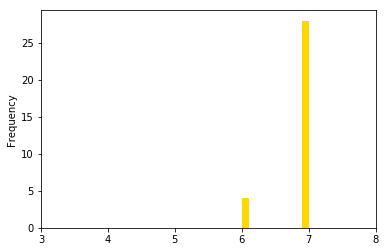

In [44]:
df_res2["worked"].plot(kind="hist", color="gold", xlim=(3,8))

In [45]:
mdl.minimize(total_overw + total_underw)
assert mdl.solve(url=url, key=key), "solve failed"
mdl.report()

* model nurses solved with objective = 4.000
*  KPI: Total salary cost  = 29594.000
*  KPI: Total over-worked  = 4.000
*  KPI: Total under-worked = 0.000


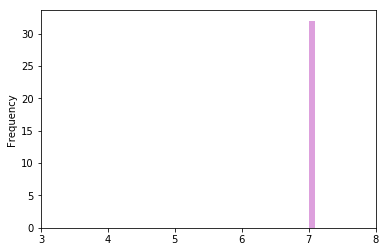

In [46]:
# Create a pandas Series containing actual shift assignment decision variables value
s_assigned_fair = df_assigned.assigned.apply(lambda v: v.solution_value)

# Create a pivot table by (nurses, shifts), using pandas' "unstack" method to transform the 'all_shifts' row index
#  into columns
df_res_fair = s_assigned_fair.unstack(level='all_shifts')

# Add a new column to the pivot table containing the #shifts worked by summing over each row
df_res_fair["solution_value_fair"] = df_res_fair[all_shifts].sum(axis=1)
df_res_fair["worked"] = df_res_fair[all_shifts].sum(axis=1)
df_res_fair["worked"].plot.hist(color="plum", xlim=(3,8))